In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pickle
import random

import pandas as pd
import numpy as np
import cv2

from sklearn.manifold import TSNE
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision

from torchvision.transforms import functional as F

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from IPython.display import Image

In [2]:
with open('../data/cifar-100-python/train', 'rb') as train_fp, \
    open('../data/cifar-100-python/meta', 'rb') as meta_fp:
    cifar_train = pickle.load(train_fp, encoding='bytes')
    cifar_meta = pickle.load(meta_fp, encoding='bytes')        

In [3]:
cifar_train.keys(), cifar_meta.keys()

(dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']),
 dict_keys([b'fine_label_names', b'coarse_label_names']))

In [4]:
len(cifar_train[b'filenames']), cifar_meta[b'fine_label_names'][cifar_train[b'fine_labels'][125]]

(50000, b'ray')

In [5]:
def show_cifar(idx, resize=False, size=(224, 224), interp=cv2.INTER_CUBIC):
    print(cifar_meta[b'fine_label_names'][cifar_train[b'fine_labels'][idx]])
    img = cifar_train[b'data'][idx].reshape((3, 32, 32)).transpose().swapaxes(0, 1)
    if resize and size:
        img = cv2.resize(img, size, interpolation=interp)
    plt.imshow(img)

b'ray'


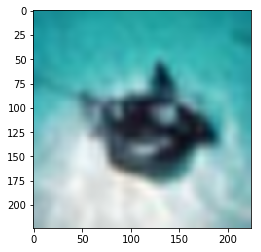

In [6]:
show_cifar(125, True)

In [34]:
train = pd.DataFrame(list(zip(cifar_train[b'data'], cifar_train[b'filenames'], cifar_train[b'fine_labels'])),
                     columns=['data', 'filename', 'label'])

In [8]:
train.head()

,data,label
0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",19
1,"[255, 253, 253, 253, 253, 253, 253, 253, 253, ...",29
2,"[250, 248, 247, 248, 249, 249, 248, 248, 247, ...",0
3,"[124, 131, 135, 138, 140, 144, 148, 152, 156, ...",11
4,"[43, 32, 87, 127, 55, 48, 51, 87, 121, 113, 13...",1


In [9]:
def to_torch(x, normalize=None):
    resized = cv2.resize(x.reshape((3, 32, 32)).transpose().swapaxes(0, 1),
                         (224, 224), 
                         interpolation=cv2.INTER_CUBIC)
    tensor = torch.from_numpy(np.moveaxis(resized / 255., -1, 0).astype(np.float32))
    if normalize:
        return F.normalize(tensor, **normalize)
    return tensor

In [10]:
sample_size = 30
class_selection = random.sample(range(100), 50)

In [35]:
df = train.groupby('label', as_index=False).apply(lambda x: x.loc[np.random.choice(x.index, sample_size, False),:])

In [37]:
images = df[df['label'].isin(class_selection)]['data'].apply(to_torch)
ncores = 4
loader = torch.utils.data.DataLoader(images.values, batch_size=ncores, shuffle=False, num_workers=1)

In [76]:
model_name = 'densenet121'
layer_name = 'features'

get_model = getattr(torchvision.models, model_name)

def extract_features(loader):
    model = get_model(pretrained=True)
    model = model.cuda()
    model.eval()

    # register hook to access to features in forward pass
    features = []
    def hook(module, input, output):
        N,C,H,W = output.shape
        output = output.reshape(N,C,-1)
        features.append(output.mean(dim=2).cpu().detach().numpy())
    handle = model._modules.get(layer_name).register_forward_hook(hook)

    for i_batch, inputs in tqdm(enumerate(loader), total=len(loader)):
        _ = model(inputs.cuda())

    features = np.concatenate(features)
    
    handle.remove()
    del model

    return features

In [38]:
features = extract_features(loader)

In [39]:
features.shape

(1500, 1024)

In [64]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
tsne_features = tsne.fit_transform(features)

In [18]:
sub_selection = random.sample(class_selection, 5)

In [75]:
def tsne_plot(tsne_features, df, class_selection, sub_selection, title):
    fig = go.Figure()
    for i in sub_selection:
        filenames = df[df['label'].isin(class_selection)][df[df['label'].isin(class_selection)]['label'] == i]['filename']
        fig.add_trace(go.Scatter(
            x=tsne_features[df[df['label'].isin(class_selection)]['label'] == i][:,0],
            y=tsne_features[df[df['label'].isin(class_selection)]['label'] == i][:,1],
            text=[str(i) for i in filenames.values],
            name=str(cifar_meta[b'fine_label_names'][i]),
            mode='markers'
        ))

    fig.update_layout(
        title=go.layout.Title(
            text=title,
        )
    )
    return fig

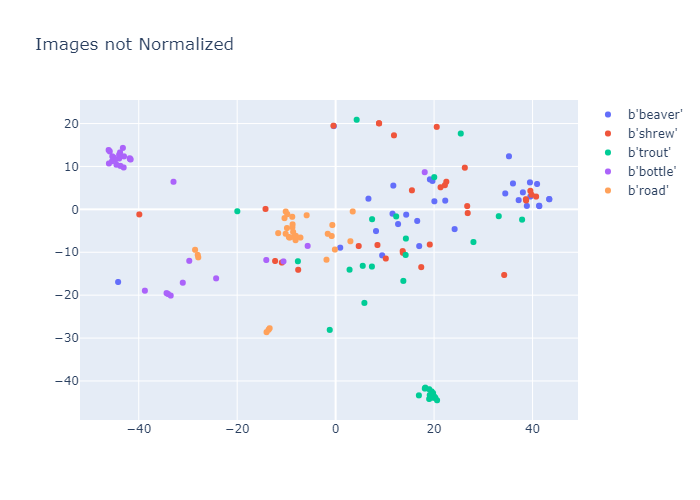

In [73]:
fig = tsne_plot(tsne_features, df, class_selection, sub_selection, 'Images not Normalized')
Image(pio.to_image(fig, format='png'))

In [74]:
fig.show()

In [68]:
df_data = np.vstack(df[df['label'].isin(class_selection)]['data'])

normalize = {
    'mean': {df_data[:,  :1024].mean(), df_data[:, 1024:2048].mean(), df_data[:, 2048:].mean()},
    'std': {df_data[:,  :1024].std(), df_data[:, 1024:2048].std(), df_data[:, 2048:].std()}
}

images = df[df['label'].isin(class_selection)]['data'].apply(to_torch, normalize)
loader = torch.utils.data.DataLoader(images.values, batch_size=ncores, shuffle=False, num_workers=1)
features = extract_features(loader)

In [70]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
tsne_features = tsne.fit_transform(features)

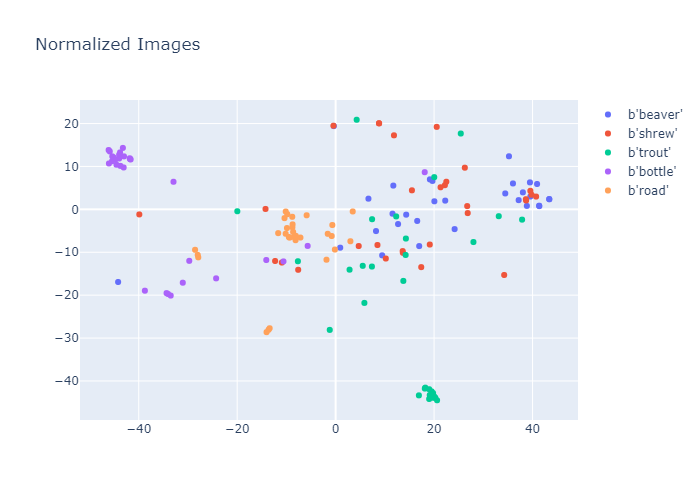

In [77]:
fig = tsne_plot(tsne_features, df, class_selection, sub_selection, 'Normalized Images')
Image(pio.to_image(fig, format='png'))

In [78]:
fig.show()